In [1]:
#Author: Maria J. Molina, National Center for Atmospheric Research
import numpy as np
import pygrib
import xarray as xr
from itertools import product
from wrf import getvar, get_basemap
from netCDF4 import Dataset
import pandas as pd
import numpy.ma as ma
from scipy.ndimage import gaussian_filter as gfilt

In [2]:
#import basemap proj from wrf
file1_wrf_d01 = '/glade/scratch/molina/wrfout_d01_2017-01-15_09:00:00'
ncfile1_wrf_d01 = Dataset(file1_wrf_d01)
while True:
    p = np.array([0])
    if len(p) == 1:
        try: 
            p = getvar(ncfile1_wrf_d01, "pressure")
        except ValueError:
            continue
    if len(p) != 1:
        print('Opened...')
        break
bmap_full = get_basemap(p)

Opened...


In [77]:
#the region and degrees to change
degrees_change = 0.5

which_region_list = np.array(['muregion_warmer','gomplume_warmer','gombasin_warmer',
                              'muregion_cooler','gomplume_cooler','gombasin_cooler'])

which_region = which_region_list[5]
deposit_files = which_region_list[5]

In [78]:
#import the narr skin sst data in netcdf
sst_data = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/perturb_skin_ssts.nc', decode_cf=True)
lons, lats = bmap_full(sst_data.coords['lon'].values, sst_data.coords['lat'].values, inverse=True)
all_times = sst_data.coords['time'].values

#import sst edge data to smooth
#sst_edge_data = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/perturb_skin_edge.nc')

#import sst edge data to smooth
sst_smooth_data = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/perturb_smooth_ssts.nc')

In [79]:
#grab the specific region data being worked on
if which_region.split('_')[0] == 'muregion':
    ssts_region = sst_data.mu_region.values
    #edge_region = sst_edge_data.mu_region_edge.values
    smooth_region = sst_smooth_data.mu_region_scat.values
if which_region.split('_')[0] == 'gomplume':
    ssts_region = sst_data.gom_plume.values
    #edge_region = sst_edge_data.gom_plume_edge.values
    smooth_region = sst_smooth_data.gom_plume_scat.values
if which_region.split('_')[0] == 'gombasin':
    ssts_region = sst_data.gom_basin.values
    #edge_region = sst_edge_data.gom_basin_edge.values
    smooth_region = sst_smooth_data.gom_basin_scat.values

In [80]:
#perturb ssts
if deposit_files.split('_')[1] == 'cooler':
    changed_sst = np.where(ssts_region>0.,ssts_region-degrees_change, ssts_region)
if deposit_files.split('_')[1] == 'warmer':
    changed_sst = np.where(ssts_region>0.,ssts_region+degrees_change, ssts_region)

In [81]:
#strings for opening files to be worked on (NARR)
all_dates_modifying = pd.date_range('2017-01-15 09:00:00', '2017-01-23 09:00:00', freq='3H').strftime('%Y%m%d%H')[:]

In [82]:
def change_grib(dataIN, dataMOD, dataEDGE):
    #Function to change the grib data and smooth edges
    newdata = np.where(dataMOD>0, dataMOD+273.15, dataIN)
    newdata = np.where(dataEDGE>0, gfilt(newdata*1.0, sigma=1.5), newdata)
    newdata = ma.masked_where(dataIN == 9999., newdata)
    return newdata


for numer_, date_ in enumerate(all_dates_modifying):
    #file to be worked on
    fileIN = 'merged_AWIP32.'+date_
    #changed file to be saved
    fileOUT = deposit_files+'_'+date_+'_'+str(float(degrees_change))+'.grb'
    #fileOUT = deposit_files+'_'+date_+'_'+str(int(degrees_change))+'.grb'
    #open the grib file
    grbsIN = pygrib.open('/glade/work/molina/DATA/NARR_GRIB/'+fileIN)
    #directory to save the changed file
    grbsOUT = open('/glade/work/molina/DATA/NARR_GRIB/'+deposit_files+'/'+fileOUT,'wb')

    for checker, grb in enumerate(grbsIN):
        #find the skin temp surface
        if grb.marsParam=='11.131' and grb.typeOfLevel=='surface':
            print('Modifying line '+str(checker+1)+'...')
            #grab the line with the sfc temp skin
            data = grb.values
            #modify function called for changing ssts
            newdata = change_grib(data, changed_sst[numer_,:,:], smooth_region)
            #replace old skin sst sfc data with new values
            grb.values = newdata
        msg = grb.tostring()
        grbsOUT.write(msg)

    grbsOUT.close()    
    grbsIN.close()
    
    print(fileOUT+' saved.')

Modifying line 267...
gombasin_cooler_2017011509_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011512_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011515_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011518_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011521_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011600_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011603_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011606_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011609_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011612_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011615_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011618_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011621_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011700_0.5.grb saved.
Modifying line 267...
gombasin_cooler_2017011703_0.5.grb saved.
Modifying line 267...
gombasin_cooler_20

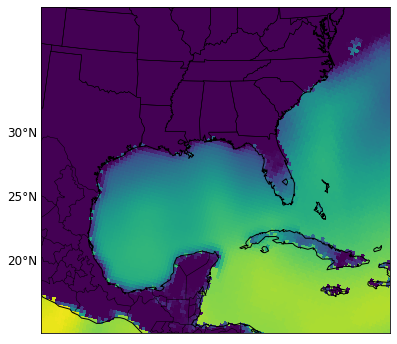

In [83]:
grbs1 = pygrib.open('/glade/work/molina/DATA/NARR_GRIB/gombasin_cooler/gombasin_cooler_2017012309_0.5.grb')
grb1 = np.array([grb for idx,grb in enumerate(grbs1) if grb.marsParam=='11.131' and grb.typeOfLevel=='surface'])[0]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8.,6))

bmap_full.drawcoastlines()
bmap_full.drawcountries()
bmap_full.drawstates()
bmap_full.drawparallels(np.arange(int(20),int(31),5),labels=[1,0,0,0], linewidth=0., fontsize=12) 

CS1 = bmap_full.pcolormesh(sst_data.coords['lon'].values, sst_data.coords['lat'].values, grb1.values-273.15,vmin=17,vmax=29)

plt.show()

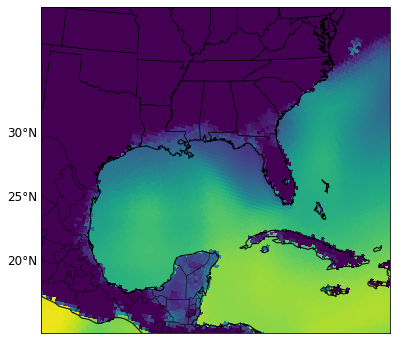

In [122]:
grbs1 = pygrib.open('/glade/work/molina/DATA/NARR_GRIB/gomplume_cooler/gomplume_cooler_2017012109_2.grb')
grb1 = np.array([grb for idx,grb in enumerate(grbs1) if grb.marsParam=='11.131' and grb.typeOfLevel=='surface'])[0]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8.,6))

bmap_full.drawcoastlines()
bmap_full.drawcountries()
bmap_full.drawstates()
bmap_full.drawparallels(np.arange(int(20),int(31),5),labels=[1,0,0,0], linewidth=0., fontsize=12) 

CS1 = bmap_full.pcolormesh(sst_data.coords['lon'].values, sst_data.coords['lat'].values, grb1.values-273.15,vmin=17,vmax=29)

plt.show()

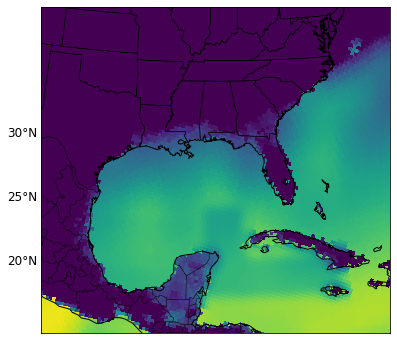

In [125]:
grbs1 = pygrib.open('/glade/work/molina/DATA/NARR_GRIB/muregion_cooler/muregion_cooler_2017012109_2.grb')
grb1 = np.array([grb for idx,grb in enumerate(grbs1) if grb.marsParam=='11.131' and grb.typeOfLevel=='surface'])[0]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8.,6))

bmap_full.drawcoastlines()
bmap_full.drawcountries()
bmap_full.drawstates()
bmap_full.drawparallels(np.arange(int(20),int(31),5),labels=[1,0,0,0], linewidth=0., fontsize=12) 

CS1 = bmap_full.pcolormesh(sst_data.coords['lon'].values, sst_data.coords['lat'].values, grb1.values-273.15,vmin=17,vmax=29)

plt.show()

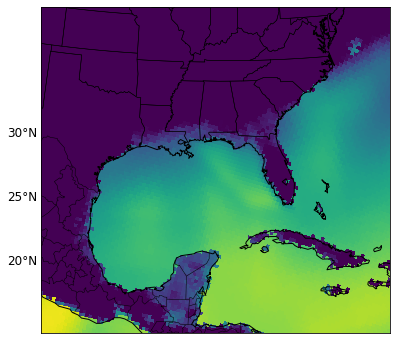

In [126]:
grbs1 = pygrib.open('/glade/work/molina/DATA/NARR_GRIB/gomplume_warmer/gomplume_warmer_2017012109_2.grb')
grb1 = np.array([grb for idx,grb in enumerate(grbs1) if grb.marsParam=='11.131' and grb.typeOfLevel=='surface'])[0]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8.,6))

bmap_full.drawcoastlines()
bmap_full.drawcountries()
bmap_full.drawstates()
bmap_full.drawparallels(np.arange(int(20),int(31),5),labels=[1,0,0,0], linewidth=0., fontsize=12) 

CS1 = bmap_full.pcolormesh(sst_data.coords['lon'].values, sst_data.coords['lat'].values, grb1.values-273.15,vmin=17,vmax=29)

plt.show()

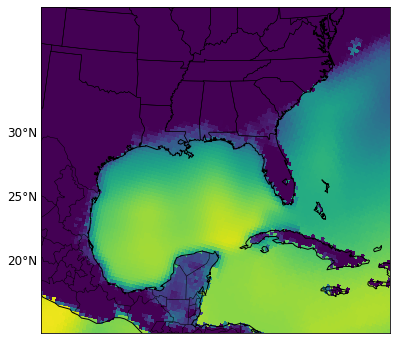

In [127]:
grbs1 = pygrib.open('/glade/work/molina/DATA/NARR_GRIB/gombasin_warmer/gombasin_warmer_2017012109_2.grb')
grb1 = np.array([grb for idx,grb in enumerate(grbs1) if grb.marsParam=='11.131' and grb.typeOfLevel=='surface'])[0]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8.,6))

bmap_full.drawcoastlines()
bmap_full.drawcountries()
bmap_full.drawstates()
bmap_full.drawparallels(np.arange(int(20),int(31),5),labels=[1,0,0,0], linewidth=0., fontsize=12) 

CS1 = bmap_full.pcolormesh(sst_data.coords['lon'].values, sst_data.coords['lat'].values, grb1.values-273.15,vmin=17,vmax=29)

plt.show()

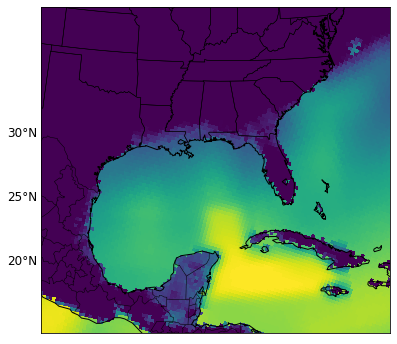

In [128]:
grbs1 = pygrib.open('/glade/work/molina/DATA/NARR_GRIB/muregion_warmer/muregion_warmer_2017012109_2.grb')
grb1 = np.array([grb for idx,grb in enumerate(grbs1) if grb.marsParam=='11.131' and grb.typeOfLevel=='surface'])[0]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8.,6))

bmap_full.drawcoastlines()
bmap_full.drawcountries()
bmap_full.drawstates()
bmap_full.drawparallels(np.arange(int(20),int(31),5),labels=[1,0,0,0], linewidth=0., fontsize=12) 

CS1 = bmap_full.pcolormesh(sst_data.coords['lon'].values, sst_data.coords['lat'].values, grb1.values-273.15,vmin=17,vmax=29)

plt.show()